# Machine Learning - Moving Linear Regression

## About the Moving Linear Regression

This type of regression to be used when data of sub periods are different inside periods. For example, hours of day, days of week, months of year.

For example, the variance of  the frequency of people in a commercial mall varies when comparing the days of the week. The same applies to an amount of cars on downtown or roads when comparing the days in a week, or even when comparing months, due to holidays and vacancies.

The chart bellow displays a seven year Moving Linear Regression applied to each month, for the number of ongoing research projects. 

## About the data
The data used this experiment is public available on the open government initiative of the State of São Paulo - Brazil.


http://catalogo.governoaberto.sp.gov.br/dataset/biblioteca-virtual-da-fapesp

Disclaimer - The only purpose of this presentation is test Machine Learning technology libraries. Check the link above, for official data.



## Machine Learning commented code

### Basic imports

Basic Python data science libraries
* Scikit Learn
* NumPy
* Pandas
* Matplotlib

In [1]:
import json
import pandas as pd
import numpy as np 
from datetime import datetime

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

today = datetime.now()

### Data preparation
Get and transform data to make a dataframe compatible with the machine learning data model shape.

In [2]:
def ano_mes_zero(row):
    # Create column year/month with 6 digits always,  for future comparison    
    if len(str(row['ano_mes'])) < 6:
        mes_dig = row['ano_mes'] - int(row['ano']) * 10
        return int('{}0{}'.format(row['ano'], mes_dig))
    else:
        return row['ano_mes']

def add_zero(today):
    # Normalizae date
    if today.month < 10:
       return '0{}'.format(str(today.month))


df = pd.read_json("../arquivos/vigentes_mes_ateh_abril2022.json")
df = pd.DataFrame (df['format_compatible'])

df[['ano', 'mes', 'aux', 'bol', 'ano_mes']] = pd.DataFrame(df.format_compatible
.tolist(), index= df.index)

df = df.drop('format_compatible', axis=1)
df[['aux', 'bol', 'ano_mes']] = df[['aux', 'bol', 'ano_mes']].astype(int)
df['ano_mes_zero'] = df.apply (lambda row: ano_mes_zero(row), axis=1)
date_filter = int('{}{}'.format(today.year, add_zero(today) ))
df = df[df['ano_mes_zero'] <= date_filter]

### Linear Regression Model

Linear Regression model, from Scikit Learn.

Function to initialize, and split data to train and test the model.

In [3]:
def lin_reg(x, y):    
    X = (x.index -  x.index[0]).values.reshape(-1, 1)    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X)  
    return (X, y_pred, regr)


### Apply Linear Regression Model to Data
After data gets transformed, applies Linear Regression to a moving dataset of the months.

In [4]:
def get_months_seq(tf):    
    """ Months - moving sequence """    
    months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

    month_today_idx = int(today.strftime("%m"))-1
    month_actual = [months[month_today_idx]]
    months_before_split = months[:month_today_idx]
    months_after_split = months[month_today_idx+1:]

    if tf == 7:
        seq = months_after_split + months_before_split + month_actual + months_after_split + months_before_split + month_actual                       
        seq *= 6
        seq.pop(-1)        
    elif tf == 21:
        seq = months_after_split + months_before_split + month_actual + months_after_split + months_before_split
    return ( month_actual[0], seq[::-1] )

def plot_line(df_slc_rev, proj):
    dataFrame = pd.DataFrame(df_slc_rev, columns=["ano", proj])
    dataFrame.plot(x="ano", y=[proj], kind="line", figsize=(10, 5))  
    
def calc_regression(df_slc_rev, proj, plot_charts):
    (X, y_pred, regr) = lin_reg(x=df_slc_rev[proj], y=df_slc_rev[proj])
    if plot_charts:    
        plt.plot(X, y_pred, color="blue", linewidth=1)
    mse = mean_squared_error(df_slc_rev[proj], y_pred, squared=False )
    return (X[-1] + 1, regr, mse)

def calc_prediction(x, regr, std, plot_charts=False):
    next_predict = ( x, regr.intercept_ + ( regr.coef_ * x ))    
    if plot_charts:
        plt.errorbar(next_predict[0], next_predict[1], std, marker='o', capsize=4)
    
def calc_projects(df_slc_rev, proj, lst_predict, plot_charts=False):
    if plot_charts:
        plot_line(df_slc_rev, proj)            
    
    (x, regr, mse) = calc_regression(df_slc_rev, proj, plot_charts)    
#     std = df_slc_rev[proj].describe()['std'].astype(int)

    if plot_charts:
        calc_prediction(x, regr, mse, plot_charts)        
        plt.grid(lw=0.3)        
        plt.show()      

    lst_predict['mes'].append( month ) 
    lst_predict['mlr'].append( regr.intercept_ + ( regr.coef_ * x )[0] )
    lst_predict['mse'].append( mse ) 

### Build data
Loop trough data, to apply the Logistic Regression to the moving dataset.

In [5]:
timeframe = 7

# Get last 7 years of next year, this year and last year, to 
# calc moving linear regression
(month_actual, months) = get_months_seq(timeframe)

"""
Linear regression for the current year, and MSE
are calculated up to the same month of the last year
"""
lst_predict_aux = {'mes':[], 'mlr':[], 'mse':[]}
lst_predict_bol = {'mes':[], 'mlr':[], 'mse':[]}

def slice_sample(timeframe, year_predict, df_month):
    df_slc = df_month[year_predict:year_predict+7]
    return(df_slc[::-1])
    
year_predict = 0
for idx, month in enumerate(months):
    if idx > 0 and (month == 'Abr'):
        year_predict += 1
        
    df_month = df.loc[df['mes'] == month]
    df_month.reset_index(drop=True, inplace=True)    
    df_slc_rev = slice_sample(timeframe, year_predict, df_month)         
    df_slc_rev.reset_index(drop=True, inplace=True)

    calc_projects(df_slc_rev, 'aux', lst_predict_aux, plot_charts=False)
    calc_projects(df_slc_rev, 'bol', lst_predict_bol, plot_charts=False)


### Plot chart

Plot data to chart
* Moving Linear Regression
* Prediction
* Deviation

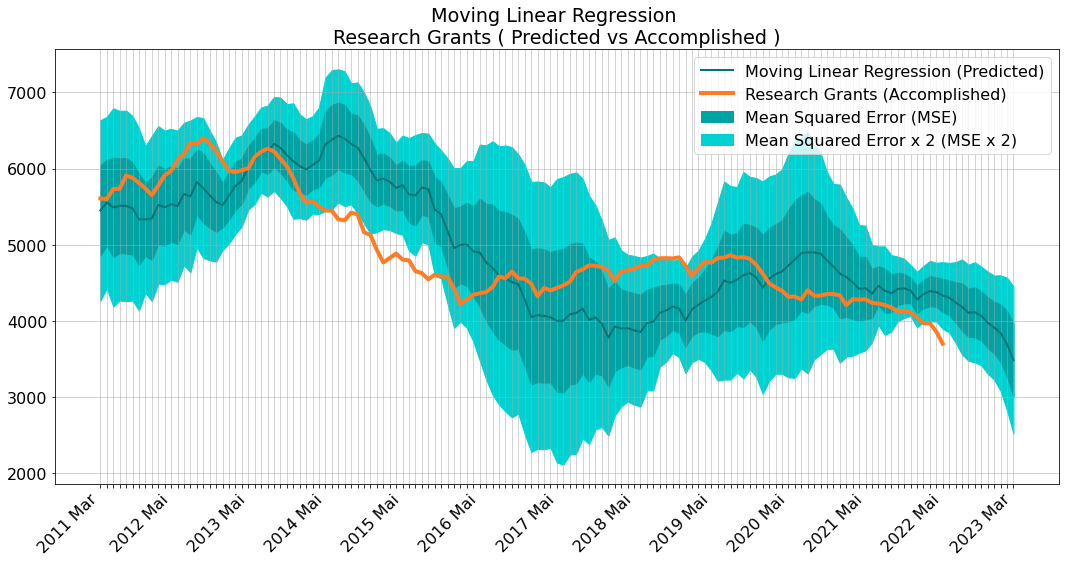

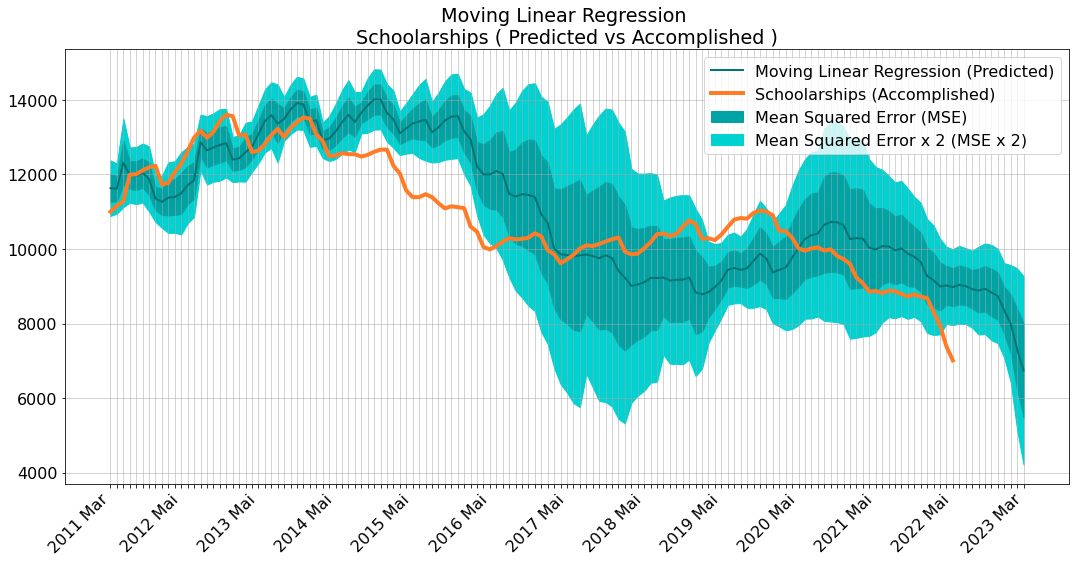

In [6]:
def plot_final(proj, lst_predict_mse):
    if proj == 'aux':
        lst_predict = lst_predict_aux
        label = 'Research Grants'
    else:
        lst_predict = lst_predict_bol
        label = 'Schoolarships'
        
    lst_predict = pd.DataFrame.from_dict(lst_predict)
    dataFrame = pd.DataFrame(lst_predict[::-1], columns=["mes", "mlr", "mse"])    
    mlr = dataFrame.reset_index(drop=True)
    accomplished = (df[len(mlr)-12::-1].reset_index(drop=True))
    final_data = mlr.join(accomplished[[proj, 'ano']], how='left')#.fillna(4000)

    # Fill next_year
    last_year = int(final_data.iloc[final_data['ano'].last_valid_index()]['ano'])
    final_data['ano'] = final_data['ano'].fillna(str(last_year+1))

    # Plot chart
    plt.figure(figsize=(18, 8))
    
    font = {'size': 16}
    plt.rc('font', **font)
    plt.title("Moving Linear Regression \n" + label + ' ( Predicted vs Accomplished )')

    
    final_data['mlr'].plot(linewidth=2, color='#007575', label='Moving Linear Regression (Predicted)')

    plt.fill_between(final_data.index.values, final_data['mlr'] - (final_data['mse'] * 2), 
                      final_data['mlr'] + (final_data['mse'] * 2), color="#00D1D1", label="Mean Squared Error x 2 (MSE x 2)")  

    plt.fill_between(final_data.index.values, final_data['mlr'] - (final_data['mse']), 
                      final_data['mlr'] + (final_data['mse']), color="#00A3A3", label="Mean Squared Error (MSE)")

    
    final_data['ano_mes'] = np.where(final_data['mes'] != month_actual, \
                                '', \
                                final_data['ano']+' ' + month_actual)


    final_data.loc[0, 'ano_mes'] = final_data['ano'][0] + ' Mar'
    final_data.iloc[-1, final_data.columns.get_loc('ano_mes')] = final_data.iloc[-1]['ano'] + ' Mar'
    final_data[proj].plot(linewidth=4, color='#FF7B25', label=label + ' (Accomplished)')
    plt.xticks(np.arange(final_data.shape[0])[::1], final_data['ano_mes'][::1], rotation=45, ha='right')
    plt.locator_params(axis='x')#, nbins=23)
    plt.grid(linewidth=0.5, color='#A9A9A9')

    # Labels and Legend
    handles, labels = plt.gca().get_legend_handles_labels()    
    order = [0,3,2,1]    
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
    
    
plot_final('aux', lst_predict_aux)
plot_final('bol', lst_predict_bol)
